# Importing and Installing Packages/Dependencies

In [1]:
%pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

  Using cached tensorflow-2.4.1-cp37-cp37m-win_amd64.whl (370.7 MB)
  Using cached tensorflow_gpu-2.4.1-cp37-cp37m-win_amd64.whl (370.7 MB)
  Using cached opencv_python-4.5.5.64-cp36-abi3-win_amd64.whl (35.4 MB)
  Using cached mediapipe-0.8.9.1-cp37-cp37m-win_amd64.whl (48.5 MB)
  Using cached sklearn-0.0-py2.py3-none-any.whl
  Using cached matplotlib-3.5.1-cp37-cp37m-win_amd64.whl (7.2 MB)
  Using cached grpcio-1.32.0-cp37-cp37m-win_amd64.whl (2.5 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached numpy-1.19.5-cp37-cp37m-win_amd64.whl (13.2 MB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached h5py-2.10.0-cp37-cp37m-win_amd64.whl (2.5 MB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached protobuf-3.19.4-cp37-cp37m-win_amd64.whl (896 kB)
  Usi

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Color conversion BGR to RGB
    image.flags.writeable = False                   # image is no longer writeable
    result = model.process(image)                   # Make prediction
    image.flags.writeable = True                    # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Color conversion RGB to BGR

    return image, result

In [4]:
def draw_landmarks(image, result):
    mp_drawing.draw_landmarks(image, result.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, result.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, result.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, result.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [30]:
def draw_styled_landmarks(image, result):
    # # Draw face connections
    # mp_drawing.draw_landmarks(image, result.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
    #                         mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
    #                         mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)) 

    # Draw pose connections
    mp_drawing.draw_landmarks(image, result.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, result.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)) 
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, result.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)) 

In [6]:
cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read the feed
        ret, frame = cap.read()

        # Make detections
        image, result = mediapipe_detection(frame, holistic)
        print(result)

        # Draw landmarks
        draw_styled_landmarks(image, result)

        # Show to screen
        cv2.imshow('Action Detection', image)
        

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

# Extract Keypoint Values

In [31]:
def extract_keypoints(result):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in result.pose_landmarks.landmark]).flatten() \
    if result.pose_landmarks else np.zeros(33*4)
    # face = np.array([[res.x, res.y, res.z] for res in result.face_landmarks.landmark]).flatten() \
    #     if result.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in result.left_hand_landmarks.landmark]).flatten() \
        if result.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in result.right_hand_landmarks.landmark]).flatten() \
        if result.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])


In [32]:
extract_keypoints(result)

NameError: name 'result' is not defined

# Setup Folders for Collection

In [33]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data')

# Actions that we try to detect
actions = np.array(['Forward', 'Stop', 'Rotate'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [34]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

Collect Keypoints Values for Training and Testing

In [35]:
cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # Loop through actions
    for action in actions:
        #Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length
            for frame_num in range(sequence_length):


                # Read the feed
                ret, frame = cap.read()

                # Make detections
                image, result = mediapipe_detection(frame, holistic)
                print(result)

                # Draw landmarks
                draw_styled_landmarks(image, result)

                # Apply wait logic
                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120,200),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 1, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video number {}'.format(action, sequence), (15,12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)

                # New exports
                keypoints = extract_keypoints(result)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Show to screen
                cv2.imshow('Action Detection', image)
        

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

# Preprocess Data and Create Labels and Features

In [36]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [37]:
label_map = {label:num for num, label in enumerate(actions)}

In [38]:
sequences, labels = [], []

for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [39]:
np.array(sequences).shape

(90, 30, 258)

In [40]:
np.array(labels).shape

(90,)

In [41]:
X = np.array(sequences)

In [42]:
y = to_categorical(labels).astype(int)
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [54]:
y_train.shape

(85, 3)

# Build and Train LSTM Neural Network

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [56]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [57]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(30,258)))
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=False, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [58]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [59]:
model.fit(X_train, y_train, epochs=500, callbacks=[tb_callback])

Epoch 1/500
3/3 [==============================] - 4s 442ms/step - loss: 1.1116 - categorical_accuracy: 0.3190
Epoch 2/500
3/3 [==============================] - 0s 127ms/step - loss: 1.1650 - categorical_accuracy: 0.2486
Epoch 3/500
3/3 [==============================] - 0s 150ms/step - loss: 1.0927 - categorical_accuracy: 0.3425
Epoch 4/500
3/3 [==============================] - 1s 171ms/step - loss: 1.0925 - categorical_accuracy: 0.3034
Epoch 5/500
3/3 [==============================] - 0s 146ms/step - loss: 1.0996 - categorical_accuracy: 0.3581
Epoch 6/500
3/3 [==============================] - 0s 156ms/step - loss: 1.0779 - categorical_accuracy: 0.4150
Epoch 7/500
3/3 [==============================] - 0s 145ms/step - loss: 1.0697 - categorical_accuracy: 0.6048
Epoch 8/500
3/3 [==============================] - 0s 144ms/step - loss: 1.0425 - categorical_accuracy: 0.6633
Epoch 9/500
3/3 [==============================] - 0s 152ms/step - loss: 1.0248 - categorical_accuracy: 0.6164
E

In [60]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 30, 128)           198144    
_________________________________________________________________
lstm_13 (LSTM)               (None, 30, 256)           394240    
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 195       
Total params: 814,467
Trainable params: 814,467
Non-trainable params: 0
________________________________________________

Make Predictions

In [61]:
res = model.predict(X_test)

In [62]:
actions[np.argmax(res[4])]

'Forward'

In [63]:
actions[np.argmax(y_test[4])]

'Forward'

Save Weights

In [64]:
model.save('action.h5')

In [146]:
del model

In [15]:

model.load_weights('action.h5')

Evaluation using CM and accuracy

In [65]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [66]:
yhat = model.predict(X_test)

In [67]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [68]:
print(ytrue)
# yhat

[2, 1, 1, 0, 0]


In [69]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[3, 0],
        [0, 2]],

       [[3, 0],
        [0, 2]],

       [[4, 0],
        [0, 1]]], dtype=int64)

In [70]:
accuracy_score(ytrue, yhat)

1.0

Test Real time

In [20]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

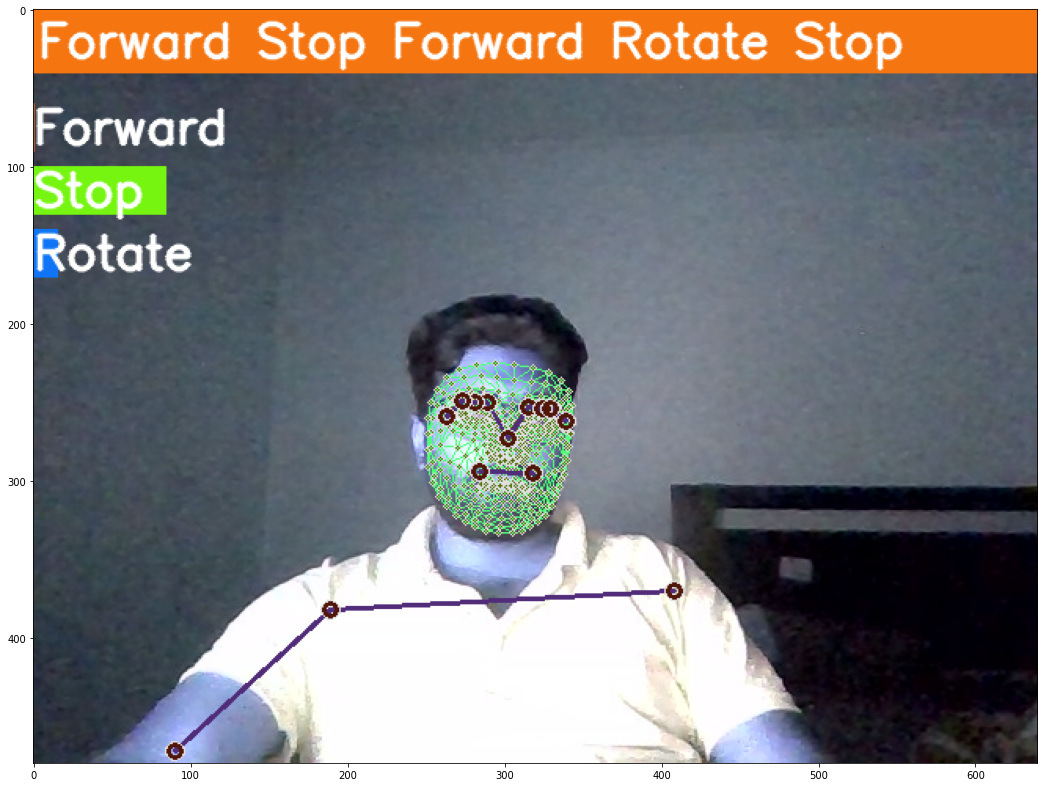

In [21]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions,image, colors))

In [72]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]
 
            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [26]:
model.predict(np.expand_dims(sequence, axis=0))[0]

array([2.3219126e-01, 7.6780868e-01, 5.5723044e-11], dtype=float32)